#### This notebook is primarly for gene filtering which encompasses:
1. removing noisy time series using autocorrelation of the signal
2. removing noisy genes by using SNR across replicates or dynamic time warping across replicates in pseudotime

#### Furthermore, the remaining data will be smoothed using some kind of windowed spline:
3. The Savitsky-Golay filter will be used to smooth both the control and treatment time series 

Note: In the R script in this codebase, the abundances and counts given by Kallisto were loaded and the low count genes were already removed from the dataset

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams.update({'figure.autolayout': True})
from copy import deepcopy
from scipy.signal import savgol_filter as savgol
import random

In [2]:
datadir = 'data/tpm_removed_low_count_genes.csv'
ntimepts = 12 # ntimepts per trajectory (replicate), 12 for monoculture experiment
reps = [0,1,2] 
df = pd.read_csv(datadir)
df_orig = deepcopy(df)
nreps = len(reps)
sampleLabels = list(df.columns[1:])
transcriptIDs = list(df.iloc[:,0])
df = df.iloc[:,1:] # first column contains transcriptIDs
df.head()

,1-Rep1_S1,1-Rep2_S25,1-Rep3_S13,1M-Rep1_S13,1M-Rep2_S1,1M-Rep3_S25,2-Rep1_S2,2-Rep2_S26,2-Rep3_S14,2M-Rep1_S14,...,11-Rep3_S23,11M-Rep1_S23,11M-Rep2_S11,11M-Rep3_S35,12-Rep1_S12,12-Rep2_S36,12-Rep3_S24,12M-Rep1_S24,12M-Rep2_S12,12M-Rep3_S36
1,266.7440,250.7110,328.0750,269.5430,271.0110,329.2010,296.9390,273.0210,281.5350,310.753,...,271.5840,240.6080,282.2160,309.3130,219.6550,277.3030,279.7380,270.2920,272.7740,290.1380
2,382.1190,332.4690,395.6170,410.2790,342.0620,398.3280,437.4590,351.8810,356.9320,440.828,...,402.6080,393.4220,401.7350,447.3310,384.6760,419.1690,434.8340,279.8320,393.6280,426.5760
3,238.7420,214.2780,227.5280,229.7400,217.1640,201.5720,239.7230,232.5230,223.8750,235.429,...,220.7000,173.8940,246.3320,232.8010,139.4350,251.1640,191.7880,196.5100,232.2930,205.6550
4,364.0790,326.2060,393.3440,386.2910,329.2040,391.3200,393.0160,333.9760,328.3530,387.486,...,358.4470,348.1310,365.8420,393.3190,337.3440,377.8250,368.4150,357.1940,366.1580,384.5620
5,46.2916,50.5114,64.8018,42.3835,50.7464,76.1887,41.0746,45.0948,42.9897,49.982,...,75.4497,75.5186,50.0142,62.9128,60.6067,55.8804,71.2058,89.7562,45.0658,60.3467


- Separate each group (control and treatment) into their own dataframes
- Select the indices corresponding to replicates of interest and return the dataframes as rank-3 tensors with each replicate's data in the third dimension

In [3]:
''' The df that is imported in the preprocess function has the following structure
    each column is a datapoint with the progression 
    t1rep1, t1rep2, t1rep3, t1Mrep1, t1Mrep2, t1Mrep3, t2rep1, ..., t12Mrep3 '''

def get_groups_from_df(data,labels): 
    ''' The df that is imported has the following structure each column is a datapoint with the progression 
    1rep1, 1rep2, 1rep3, 1Mrep1, 1Mrep2, 1Mrep3, 2rep1, ..., 12Mrep3 .
    This functions builds the two matrices (one per group) 1rep1, 1rep2, 1rep3, ..., 12rep1, 12rep2, 12rep3
    1Mrep1, 1Mrep3, 1Mrep3, ..., 12Mrep1, 12Mrep2, 12Mrep3 '''
    data_c = np.zeros([data.shape[0],int(data.shape[1]/2)]) # c for control
    data_t = np.zeros([data.shape[0],int(data.shape[1]/2)]) # t for treatment
    c = 0
    ct = 0
    for i in range(0,data.shape[1]):
        if 'M' not in labels[i]: # 'M' stands for malathion (the treatment of group 2) in the labels
            data_c[:,c] = data[:,i]
            c += 1
        elif 'M' in labels[i]:
            data_t[:,ct] = data[:,i]
            ct += 1
    return data_c, data_t

def get_reps(reps,ntimepts):
    ''' get the columns inds of the replicates to keep. the conditions should already be 
    separated into their own dataframes/arrays for this to make sense.'''
    nreps = 3
    allinds = set(list(range(0,ntimepts*nreps)))
    if reps == [0]:
        keepers = list(allinds - set(list(range(1,ntimepts*nreps,3))) - set(list(range(2,ntimepts*nreps,3))))
    elif reps == [1]:
        keepers = list(allinds - set(list(range(0,ntimepts*nreps,3))) - set(list(range(2,ntimepts*nreps,3))))
    elif reps == [2]:
        keepers = list(allinds - set(list(range(0,ntimepts*nreps,3))) - set(list(range(1,ntimepts*nreps,3))))
    elif reps == [0,1]: # set subtract column inds for rep3 from allinds
        keepers = list(allinds - set(list(range(2,ntimepts*nreps,3)))) # column inds for rep1 and rep2
    elif reps == [0,2]: # set subtract column inds for rep2 from allinds
        keepers = list(allinds - set(list(range(1,ntimepts*nreps,3)))) # column inds for rep1 and rep3
    elif reps == [1,2]: # set subtract column inds for rep1 from allinds
        keepers = list(allinds - set(list(range(0,ntimepts*nreps,3))))
    elif reps == [0,1,2]:
        keepers = list(allinds)
    keepers.sort()
    return keepers

def put_groups_in_3D(data,nTraj,nT):
    '''Data from each trajectory (replicate) is placed in a new 2d array which is appended to one 3d array of 
    dimension n x m x r. n is number of genes, m is number of timepoints, r is number of replicates.'''
    X = np.zeros((data.shape[0],nT,nTraj))
    reps = list(range(0,nTraj))
    for i in reps:
        X[:,:,i] = data[:,get_reps([i],nT)]
    return X

- Smooth the data
- Compute distance b/w smoothed and raw time series
- Compute autocorrelations of each gene's time series

In [4]:
def smooth_time_series(data,window_size=3,polyorder=1):
    '''Using scipy's Savitsky-Golay filter to smooth the data. window_size must be an odd number 
    and greater than polyorder'''
    return savgol(data,window_size,polyorder,axis=1)

def dist_bw_smooth_raw(raw,smooth):
    dist = np.linalg.norm(raw-smooth,ord=2,axis=1) / np.linalg.norm(raw,ord=2,axis=1)
    mean_dist = np.mean(dist,axis=1)
    stdev_dist = np.std(dist,axis=1)
    return dist,mean_dist,stdev_dist

def acorr(x):
    x = x - x.mean()
    autocorr = np.correlate(x, x, mode='full')
    autocorr /= autocorr.max()
    autocorr = autocorr[len(x)-1:]
    return autocorr

In [5]:
# get data in desired format
data_c, data_t = get_groups_from_df(np.array(df),sampleLabels) 
data_c, data_t = put_groups_in_3D(data_c,nreps,ntimepts), put_groups_in_3D(data_t,nreps,ntimepts)
# first two timepoints are pre-treatment. last timepoint is also anomalous.
data_c, data_t = data_c[:,2:-1], data_t[:,2:-1] 
# background subtract
data_bs = np.maximum(data_t - data_c,0.0)
# smooth the data with Savitsky-Golay filter
window_size = 7 # for savgol_filter
polyorder = 3
data_c_smooth = smooth_time_series(data_c,window_size=window_size,polyorder=polyorder)
data_t_smooth = smooth_time_series(data_t,window_size=window_size,polyorder=polyorder)
data_bs_smooth = np.maximum(data_t_smooth - data_c_smooth,0.0)

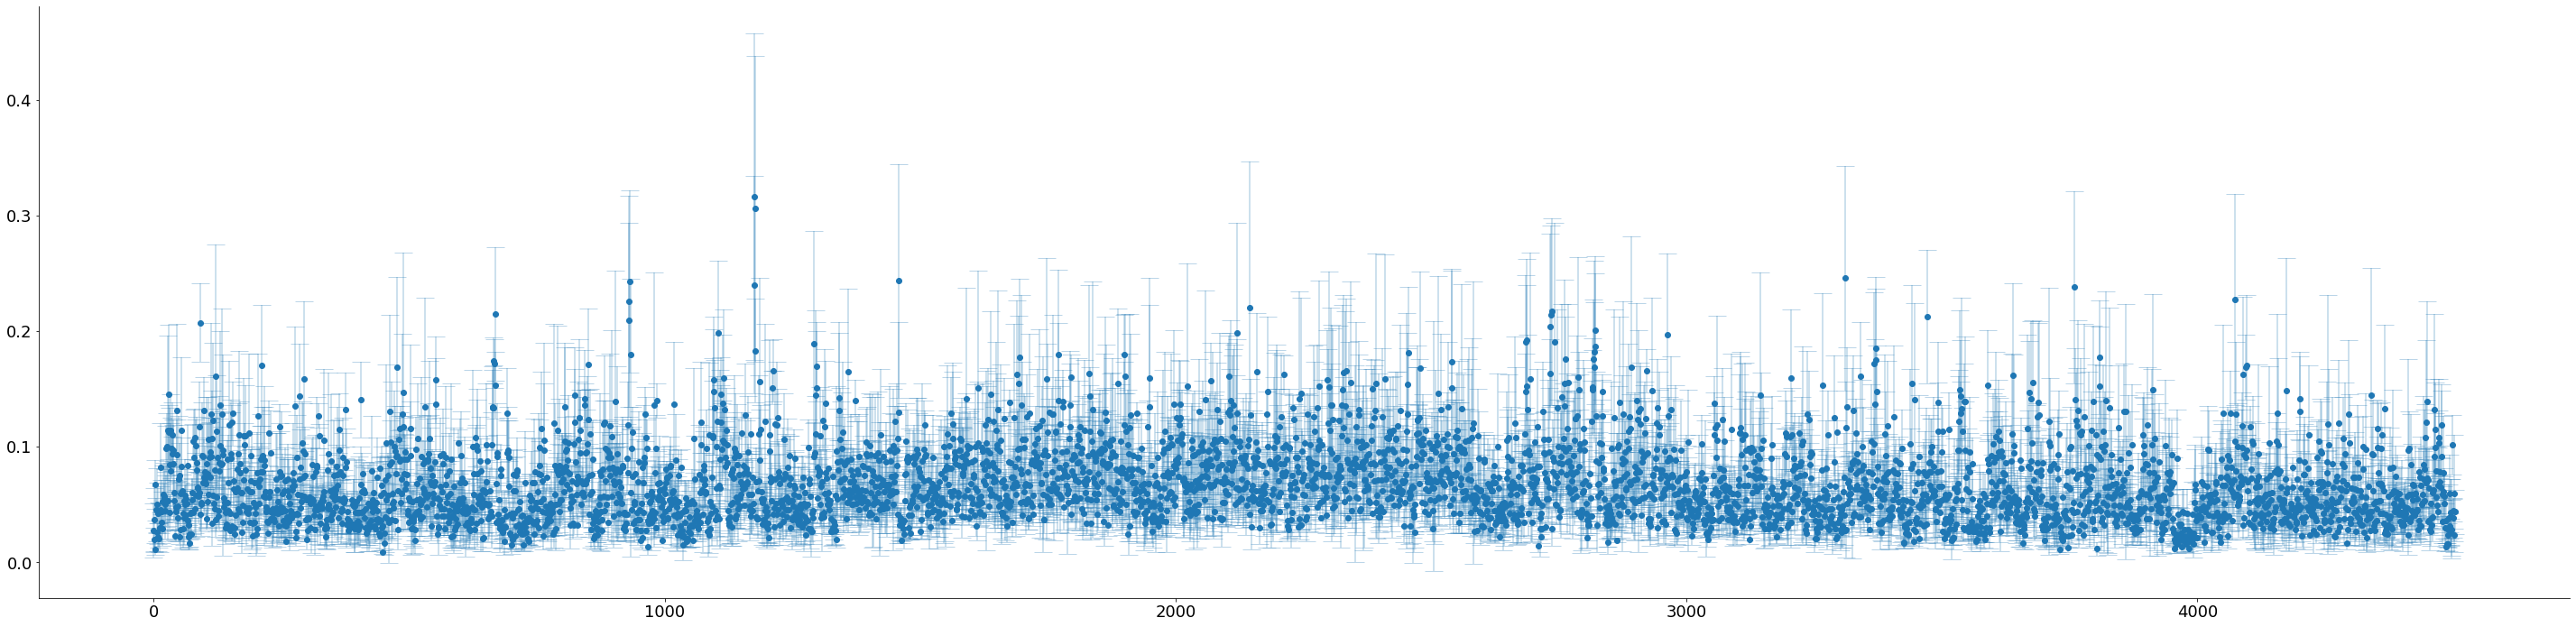

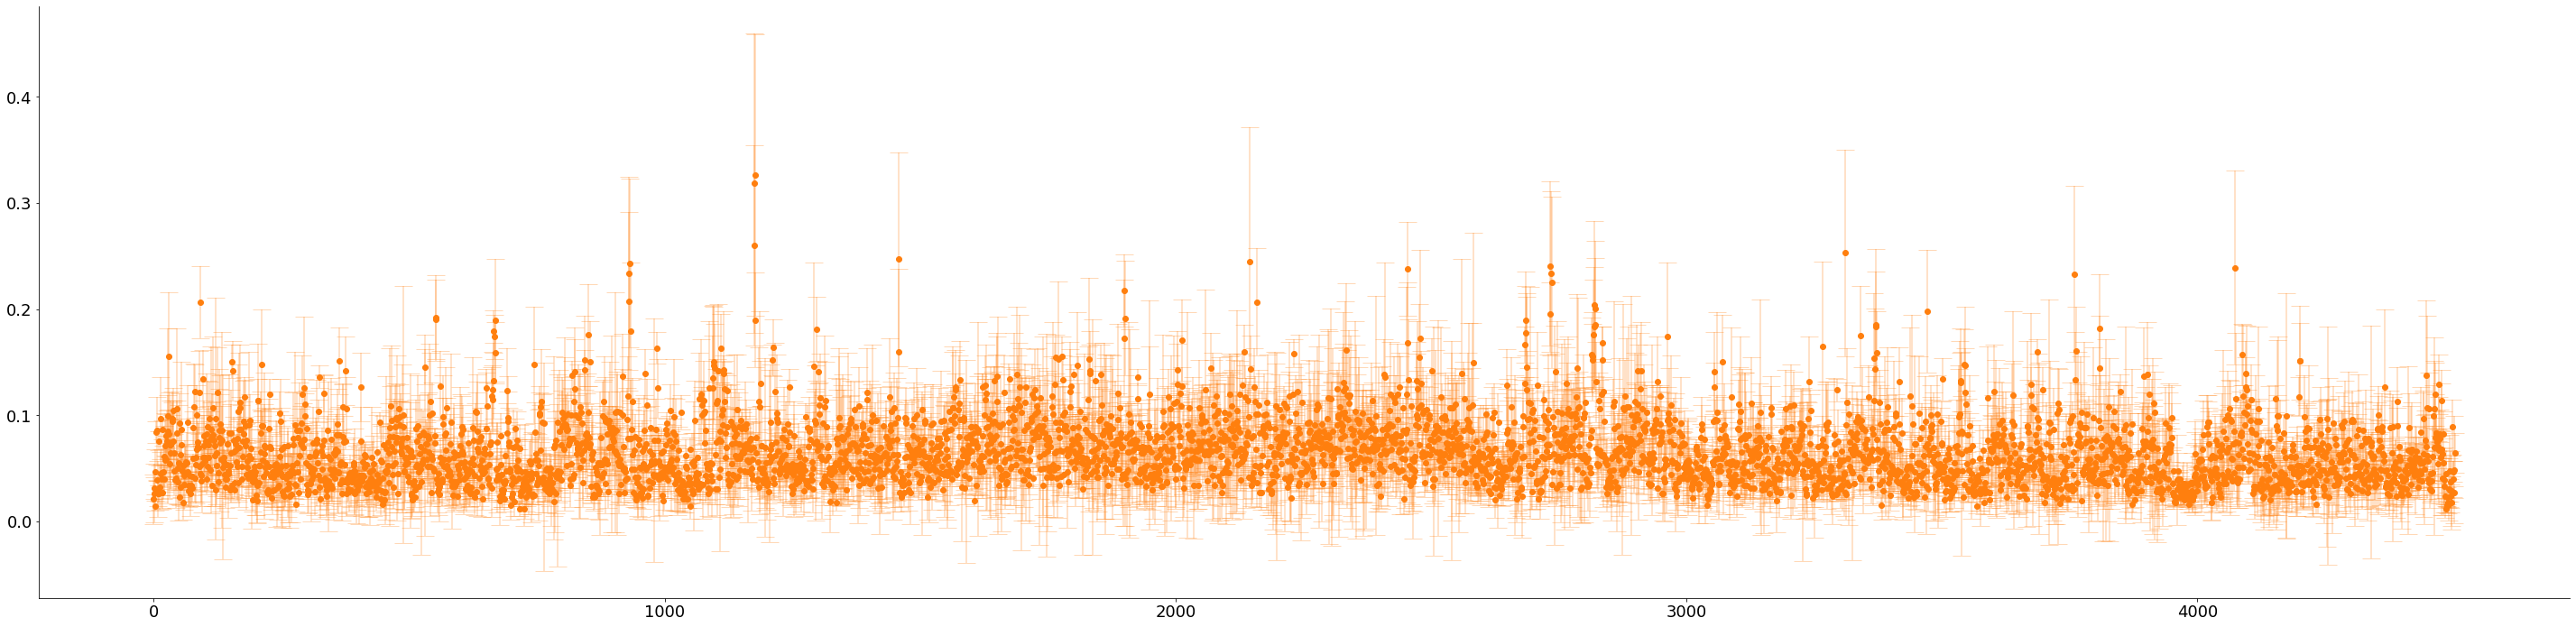

In [6]:
# What do the distances b/w the raw and smooth curves look like? 
dist_c,mean_dist_c,stdev_dist_c = dist_bw_smooth_raw(data_c,data_c_smooth)
dist_t,mean_dist_t,stdev_dist_t = dist_bw_smooth_raw(data_t,data_t_smooth)
plt.figure(figsize=(40,10));
plt.plot(mean_dist_c,'o')
plt.errorbar(list(range(len(mean_dist_c))),mean_dist_c,yerr=stdev_dist_c,fmt='.',ms=0,color='tab:blue',capsize=10,alpha=0.3);
plt.figure(figsize=(40,10));
plt.plot(mean_dist_t,'o',color='tab:orange')
plt.errorbar(list(range(len(mean_dist_t))),mean_dist_t,yerr=stdev_dist_c,fmt='.',ms=0,color='tab:orange',capsize=10,alpha=0.3);
# I can't conclude much from this, so I think it may be best to smooth every gene's time series. 
# Also should we be interpolating to increase the number of timepoints?? 

- Plotting 

In [94]:
def plot_single_series(data0,data1,data0smooth,data1smooth,databs,databssmooth,geneidx=0):
    '''
    Plot raw data (control, treatment, and background subtracted).
    Plot smoothed data (control, treatment, and background subtracted).
    Plot autocorrelations of raw and smoothed control and treatment.
    '''
    nrows,ncols=2,3
    fig,axs = plt.subplots(nrows,ncols,figsize=(10,4))
    for ii in range(data0.shape[2]):
        axs[0,0].plot(data0[geneidx,:,ii]);
        axs[1,0].plot(data0smooth[geneidx,:,ii]);
        axs[0,1].plot(data1[geneidx,:,ii]);
        axs[1,1].plot(data1smooth[geneidx,:,ii]);
        axs[0,2].plot(databs[geneidx,:,ii]);
        axs[1,2].plot(databssmooth[geneidx,:,ii]);
    axs[0,0].set_title('Negative control (raw)',fontsize=12)
    axs[1,0].set_title('Negative control (filtered)',fontsize=12)
    axs[0,1].set_title('Treatment (raw)',fontsize=12)
    axs[1,1].set_title('Treatment (filtered)',fontsize=12)
    axs[0,2].set_title('bgs (raw)',fontsize=12)
    axs[1,2].set_title('filtered data bgs',fontsize=12)
    for ii in range(nrows):
        axs[ii,0].set_ylabel('TPM')
    for jj in range(ncols):
        axs[-1,jj].set_xlabel('time point')
    plt.tight_layout();

    nrows,ncols=4,3
    fig,axs = plt.subplots(nrows,ncols,figsize=(10,8))
    for ii in range(data0.shape[2]):
        axs[0,ii].plot(data0[geneidx,:,ii]);
        axs[0,ii].plot(data1[geneidx,:,ii]);
        axs[1,ii].plot(data0smooth[geneidx,:,ii]);
        axs[1,ii].plot(data1smooth[geneidx,:,ii]);
        axs[2,ii].plot(databs[geneidx,:,ii],color='tab:red');
        axs[3,ii].plot(databssmooth[geneidx,:,ii],color='tab:red');
    axs[0,0].set_title('Replicate 1 (raw)',fontsize=12)
    axs[0,1].set_title('Replicate 2 (raw)',fontsize=12)
    axs[0,2].set_title('Replicate 3 (raw)',fontsize=12)
    axs[1,0].set_title('Replicate 1 (filtered)',fontsize=12)
    axs[1,1].set_title('Replicate 2 (filtered)',fontsize=12)
    axs[1,2].set_title('Replicate 3 (filtered)',fontsize=12)
    axs[2,0].set_title('Replicate 1 (raw) bgs',fontsize=12)
    axs[2,1].set_title('Replicate 2 (raw) bgs',fontsize=12)
    axs[2,2].set_title('Replicate 3 (raw) bgs',fontsize=12)
    axs[3,0].set_title('Replicate 1 (filtered) bgs',fontsize=12)
    axs[3,1].set_title('Replicate 2 (filtered) bgs',fontsize=12)
    axs[3,2].set_title('Replicate 3 (filtered) bgs',fontsize=12)
    for ii in range(nrows):
        axs[ii,0].set_ylabel('TPM')
    for jj in range(ncols):
        axs[-1,jj].set_xlabel('time point')
    plt.tight_layout();
    
    nrows,ncols=2,2
    fig,axs = plt.subplots(nrows,ncols,figsize=(10,5))
    colors=['C0o','C1o','C2o']
    labels=['R1','R2','R3']
    for ii in range(data0.shape[2]):
        axs[0,0].stem(acorr(data0[geneidx,:,ii]),linefmt='C7',markerfmt=colors[ii],label=labels[ii]);
        axs[0,1].stem(acorr(data1[geneidx,:,ii]),linefmt='C7',markerfmt=colors[ii],label=labels[ii]);
        axs[1,0].stem(acorr(data0smooth[geneidx,:,ii]),linefmt='C7',markerfmt=colors[ii],label=labels[ii]);
        axs[1,1].stem(acorr(data1smooth[geneidx,:,ii]),linefmt='C7',markerfmt=colors[ii],label=labels[ii]);
#     plt.xlabel('Lag');
#     plt.ylabel('Autocorrelation');
    for ii in range(nrows):
        axs[ii,0].set_ylabel('Autocorrelation')
        axs[-1,ii].set_xlabel('Lag')
        for jj in range(2):
            axs[ii,jj].legend(fontsize=10);
    axs[0,0].set_title('negative control (raw)',fontsize=14)
    axs[0,1].set_title('treatment (raw)',fontsize=14)
    axs[1,0].set_title('negative control (filtered)',fontsize=14)
    axs[1,1].set_title('treatment (filtered)',fontsize=14)
    plt.tight_layout();


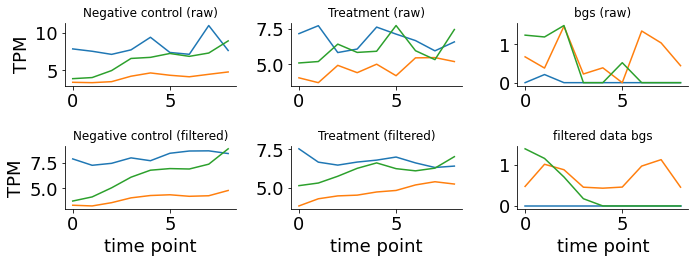

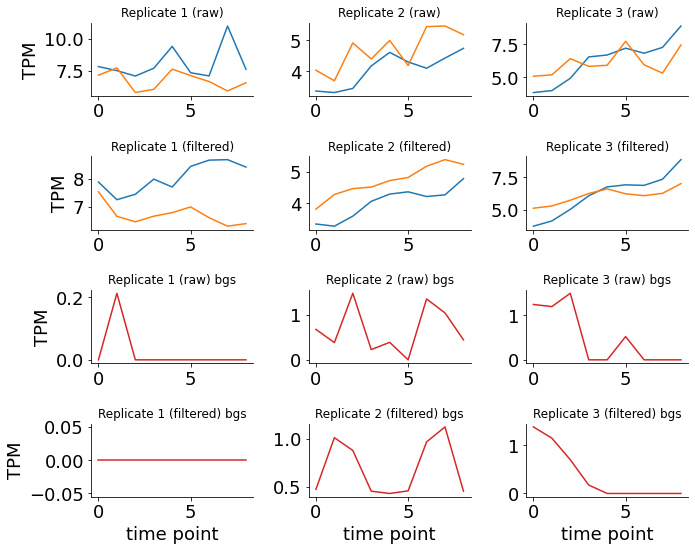

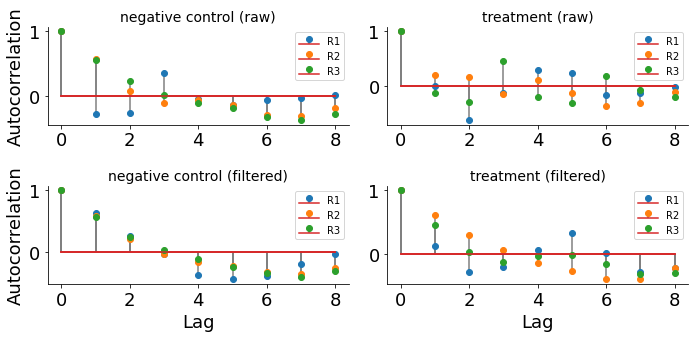

In [95]:
k = np.random.randint(0,len(data_c))
plot_single_series(data_c,data_t,data_c_smooth,data_t_smooth,data_bs,data_bs_smooth,geneidx=k)

- Criteria to determine if gene has noisy time series: Autocorrelation at first few lags is very small
- Estimation of autocorrelation decreases in accuracy as lag increases, so we consider first few lags only
- Should not use autocorrelation of filtered data because any noise passed through a filter will be given a relationship induced by the filter
- A note: turns out that a white noise process, when filtered using something like Savitsky-Golay with a large enough window length will transform into a nearly constant signal. This can explain the reasoning behind the genes that were considered to be noisy via the autocorrelation approach.

In [204]:
def autocorrelation_all_data(data):
    acorr_all = np.empty((data.shape))
    for ii in range(data.shape[0]):
        for jj in range(data.shape[2]):
            acorr_all[ii,:,jj] = acorr(data[ii,:,jj])
    return acorr_all

acorr_c,acorr_t = autocorrelation_all_data(data_c),autocorrelation_all_data(data_t)
# grab just the first three lags, excluding the zero lag of course. 
acorr_c,acorr_t = acorr_c[:,1:4,:], acorr_t[:,1:4,:]

def autocorrelation_filter(acorr_data,thresh=0.1):
    # set autocorrelation to 0.0 if it is less than thresh, otherwise set it to 1.0
    acorr_thresh = (np.abs(acorr_data) > thresh)*acorr_data 
    acorr_thresh[np.abs(acorr_thresh) > 0.0] = 1.0
    # if at least L of the autocorrelations (at lags) in each replicate are greater than thresh, 
    # that gene is labeled as non-noisy. To check this criteria, the sum of each row of acorr_thresh 
    # should be greater than or equal to L and then sum of the resulting row (sum over each replicate) 
    # should then be greater than or equal to 3 where boolean matrices are used each step of the way
    L = 1
    acorr_thresh_sum = np.sum(acorr_thresh,axis=1)  
    acorr_thresh_sum = (acorr_thresh_sum >= L) * acorr_thresh_sum
    acorr_thresh_sum[acorr_thresh_sum > 0.0] = 1.0
    acorr_thresh_sum = np.sum(acorr_thresh_sum,axis=1)
    keepers = list((np.nonzero((acorr_thresh_sum == 3) * acorr_thresh_sum))[0]) # 3 as that is # of trajectories
    return keepers

keepers_acorr_c,keepers_acorr_t = autocorrelation_filter(acorr_c), autocorrelation_filter(acorr_t)
keepers_acorr = list(set(keepers_acorr_c) & set(keepers_acorr_t))
notkeep_acorr = list(set(list(range(len(df)))) - set(keepers_acorr))
print(len(keepers_acorr),len(notkeep_acorr))

4093 412


684


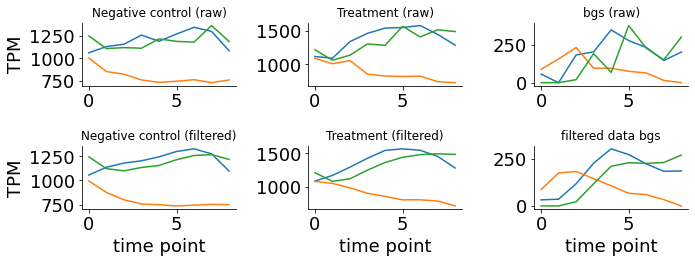

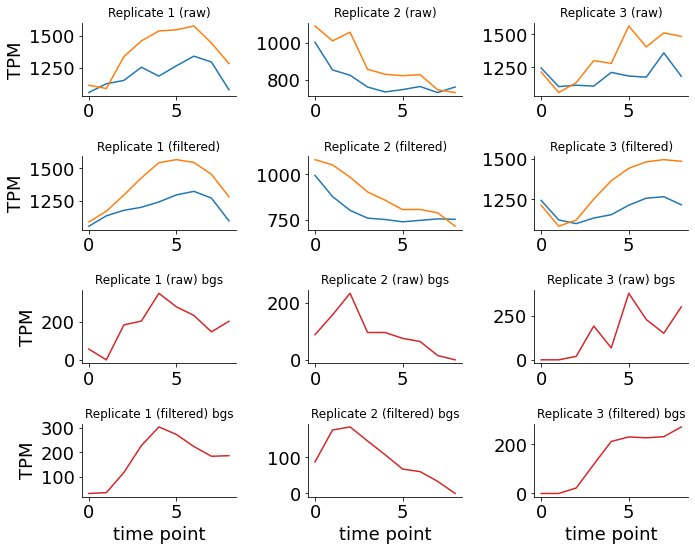

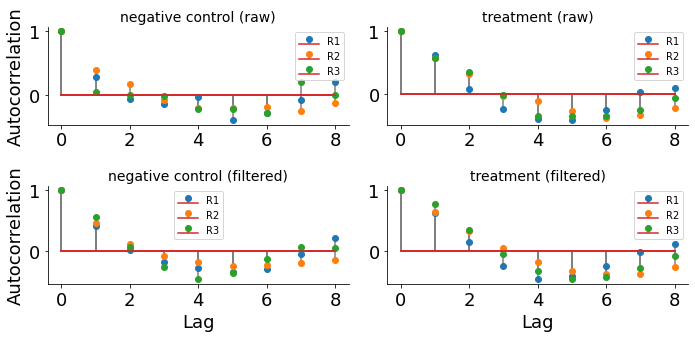

In [115]:
# plot a random noisy gene 
k = random.choice(notkeep_acorr)
print(k)
plot_single_series(data_c,data_t,data_c_smooth,data_t_smooth,data_bs,data_bs_smooth,geneidx=k)

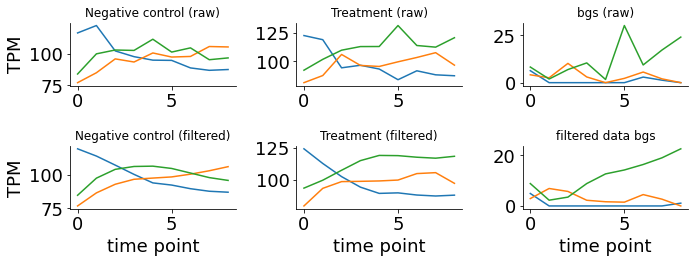

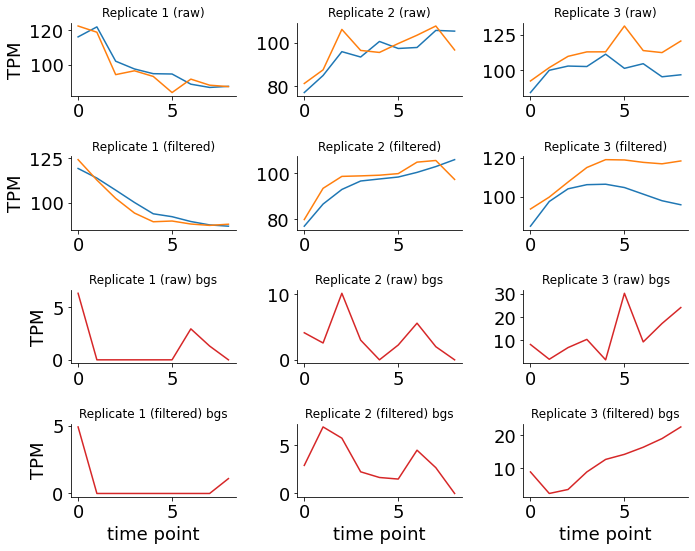

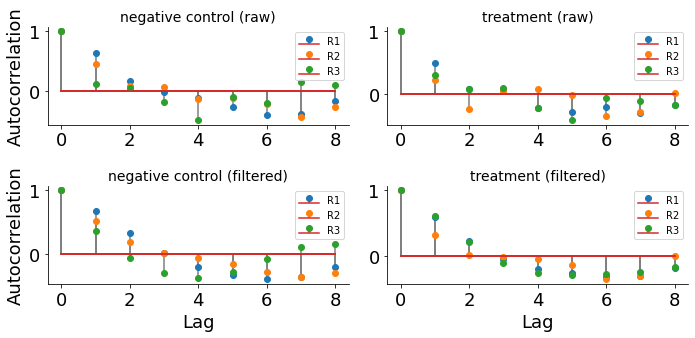

In [116]:
# plot a random non-noisy gene
k = random.choice(keepers_acorr)
plot_single_series(data_c,data_t,data_c_smooth,data_t_smooth,data_bs,data_bs_smooth,geneidx=k)